## 4) Write your own codes for Lane Detection

In [18]:
import numpy as np
import cv2

def set_region_of_interest(img, vertices):
    '''
    영상에서 관심 영역만 남김
    
    Parameters
    ----------
    img: array
        적용할 타겟 영상
    vertices: list of points
        관심 영역의 좌표점들이 저장된 리스트
    '''
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    
    return cv2.bitwise_and(img, mask)

In [19]:
def full_pipeline(img):
    '''
    차선 검출을 위한 전체 파이프라인 코드
    '''
    height, width = img.shape[:2]
    
    vertices = np.array([[(50,height),
                          (width/2-45, height/2+60), 
                          (width/2+45, height/2+60), 
                          (width-50,height)]], 
                        dtype=np.int32)
    

    ## 1) 명암 영상에서 엣지 정보를 찾기 위해 영상의 색 공간 변환
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ## 2) (optional) 영상 내의 노이즈를 감소시키기 위해 스무딩 효과 적용 (cv2.Canny()에 구현되어있지 않음)
    blur_img = cv2.GaussianBlur(gray_img, (3, 3), 0)

    ## 3) Canny edge detection을 사용하여 엣지 영상 검출
    edge_img = cv2.Canny(blur_img, 
                         threshold1=70,   # gradient의 강도 < threshold1인 경우 무조건 엣지가 아니라고 판단
                         threshold2=175)  # gradient의 강도 > threshold2인 경우 무조건 엣지라고 판단(강한 엣지)
                                          # threshold1 < gradient의 강도 < threshold2인 경우 강한 엣지와 연결되어 있는 경우에만 엣지라고 판단
    
    ## 4) 타겟 차선 이외 부분에서의 엣지는 고려하지 않기 위해 영상에서 관심 영역만 남김
    roi_img = set_region_of_interest(edge_img, vertices)

    ## 5) Hough transform을 사용하여 조건을 만족하는 직선을 모두 검출
    lines = cv2.HoughLinesP(roi_img, 
                            rho=1,            # rho값의 범위 (0~1 실수)
                            theta=np.pi/180,  # theta값의 범위(0~180 정수)
                            threshold=10,     # 변환 공간에서 만나는 점의 개수 기준
                            minLineLength=15, # 직선이 만족해야하는 최소 길이
                            maxLineGap=5)     # 얼마만큼 떨어져 있어도 하나의 직선으로 볼 것인지
    
    ## 6) 찾은 직선을 결과 영상에 그리기
    result = np.copy(img)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(result, (x1, y1), (x2, y2), color=(0,0,255), thickness=5)
    
    return result

In [20]:
listOfFiles = ['solidWhiteRight.jpg', 'solidYellowLeft.jpg']

for i, file in enumerate(listOfFiles):
    img = cv2.imread(file)
    
    result = full_pipeline(img)
    cv2.imshow('lane detection', result)
    cv2.imwrite('lane detection.jpg', result)
    cv2.waitKey(0) 
    
cv2.destroyAllWindows()

# ※ Challenging case

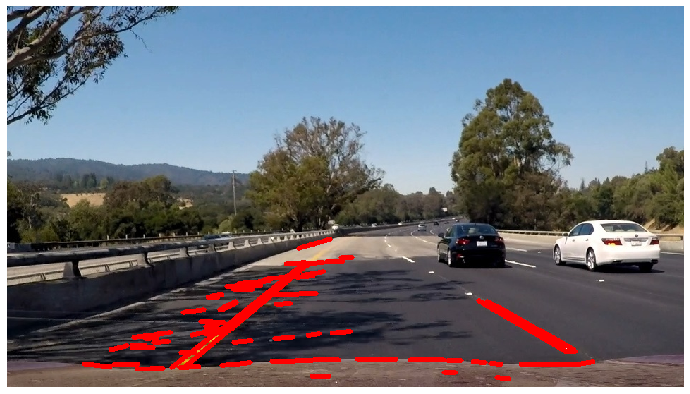

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('challenge.jpg')

result = full_pipeline(img)

plt.figure(figsize=(15,7))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 5) Further improvements

In [22]:
class Line:
    '''
    하나의 직선에 대한 기울기와 y절편 정보를 갖는 클래스    
    '''
    def __init__(self, x1, y1, x2, y2):
        self.x1 = float(x1)
        self.y1 = float(y1)
        self.x2 = float(x2)
        self.y2 = float(y2)

        self.slope = self.compute_slope()
        self.bias = self.compute_bias()

    def compute_slope(self):
        return (self.y2 - self.y1) / (self.x2 - self.x1 + 1e-7)  # 1e-7은 분모가 0이 되는 것을 방지하기 위함

    def compute_bias(self):
        return self.y1 - self.slope * self.x1

    def get_coords(self):
        return np.array([self.x1, self.y1, self.x2, self.y2])

    def set_coords(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def draw(self, img, color=(0,0,255), thickness=5):
        cv2.line(img, (int(self.x1), int(self.y1)), (int(self.x2), int(self.y2)), color, thickness)

In [23]:
import numpy as np
import cv2

def set_region_of_interest(img, vertices):
    '''
    영상에서 관심 영역만 남김
    
    Parameters
    ----------
    img: array
        적용할 타겟 영상
    vertices: list of points
        관심 영역의 좌표점들이 저장된 리스트
    '''
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    
    return cv2.bitwise_and(img, mask)


def get_lanes(lines, y_end):
    '''
    후보 직선 리스트를 입력으로 받아 차선에 해당하는 두 직선(좌측, 우측)을 계산함
    
    Parameters
    ----------
    lines: list of Line instances
        후보 Line 인스턴스들의 리스트
    y_end: int
        차선 직선의 끝점을 계산하기 위한 영상의 높이 정보
    '''
    ## 음수 기울기(좌측 차선)를 갖는 직선들과 양수 기울기(우측 차선)를 갖는 직선들로 분류
    neg_lines = [line for line in lines if line.slope < -0.3]  # 수평에 가까운 직선을 제거하기 위한 기울기 임계값 사용
    pos_lines = [line for line in lines if 0.3 < line.slope]
    
    ## 후보 직선들 중 중앙값에 해당하는 직선을 대표 직선으로 선택
    left_line_bias = np.median([line.bias for line in neg_lines]).astype('int32')
    left_line_slope = np.median([line.slope for line in neg_lines])
    
    right_line_bias = np.median([l.bias for l in pos_lines]).astype('int32')
    right_line_slope = np.median([l.slope for l in pos_lines])
    
    ## 소실점(vanishing point)을 기반으로 차선의 시작점 설정
    ## 두 직선(y = a1x + b1, y = a2x + b2)의 교점을 소실점으로 고려하여 계산
    vanishing_y = int(left_line_slope*right_line_bias - right_line_slope*left_line_bias) /(left_line_slope-right_line_slope)
    offset = int(y_end*0.05)          # 임의의 오프셋 설정
    y_init = vanishing_y + offset

    ## 각 차선의 시작점과 끝점 좌표 계산
    x1, y1 = 0, left_line_bias
    x2, y2 = int((y_init - left_line_bias) / left_line_slope), y_init
    lLane = Line(x1, y1, x2, y2)

    x1, y1 = int((y_init - right_line_bias) / right_line_slope), y_init
    x2, y2 = int((y_end - right_line_bias) / right_line_slope), y_end
    rLane = Line(x1, y1, x2, y2)

    return lLane, rLane

In [24]:
def improved_pipeline(img):
    '''
    차선 검출을 위한 개선된 전체 파이프라인 코드
    '''
    height, width = img.shape[:2]
    vertices = np.array([[(50, height),
                          (width/2-45, height/2+60), 
                          (width/2+45, height/2+60), 
                          (width-50,height)]], 
                          dtype='int')

    ## 1) 명암 영상에서 엣지 정보를 찾기 위해 영상의 색 공간 변환
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ## 2) 영상 내의 노이즈를 감소시키기 위해 스무딩 효과 적용 (cv2.Canny()에 구현되어있지 않음)
    ## https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#gaussianblur
    blur_img = cv2.GaussianBlur(gray_img, (3, 3), 0)

    ## 3) Canny edge detection을 사용하여 엣지 영상 검출
    edge_img = cv2.Canny(blur_img, 
                         threshold1=70,   # gradient의 강도가 threshold1보다 작으면 무조건 엣지가 아니라고 판단
                         threshold2=175)  # gradient의 강도가 threshold2보다 크면 무조건 엣지라고 판단, 
                                          # gradient의 강도가 threshold1과 threshold2 사이이면 주변에 연결된 화소 정보를 보고 판단
    
    ## 4) 타겟 차선 이외 부분에서의 엣지는 고려하지 않기 위해 영상에서 관심 영역만 남김
    roi_img = set_region_of_interest(edge_img, vertices)

    ## 5) Hough transform을 사용하여 조건을 만족하는 직선을 모두 검출
    lines = cv2.HoughLinesP(roi_img, 
                            rho=1,            # rho값의 범위 (0~1 실수)
                            theta=np.pi/180,  # theta값의 범위(0~180 정수)
                            threshold=10,     # 변환 공간에서 만나는 점의 개수 기준
                            minLineLength=15, # 직선이 만족해야하는 최소 길이
                            maxLineGap=5)     # 얼마만큼 떨어져 있어도 하나의 직선으로 볼 것인지
    
    ## 6) 차선을 대표하는 두 직선 계산
    candidate_lines = [Line(*line[0]) for line in lines]
    lLane, rLane = get_lanes(candidate_lines, y_end=height)
    
    ## 7) 결과 차선을 각각 결과 영상에 그리기
    line_img = np.zeros_like(img)
    lLane.draw(line_img)
    rLane.draw(line_img)
    result = cv2.addWeighted(img, 1.0, line_img, 1.0, 0.0)
    
    return result

In [25]:
listOfFiles = ['solidWhiteRight.jpg', 'solidYellowLeft.jpg', 'challenge.jpg']

for i, file in enumerate(listOfFiles):
    img = cv2.imread(file)
    
    result = improved_pipeline(img)
    cv2.imshow('lane detection', result)
    cv2.waitKey(0) 
    
cv2.destroyAllWindows()